In [11]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("GPU Memory (GB):", torch.cuda.get_device_properties(0).total_memory / 1e9)


Using device: cuda
GPU Name: NVIDIA GeForce GTX 1650
GPU Memory (GB): 3.896180736


In [10]:
# !pip install seaborn

In [13]:
np.random.seed(42)

data = {
    "quiz_score": np.random.randint(30, 100, 500),
    "time_spent": np.random.randint(5, 90, 500),
    "attempts": np.random.randint(1, 5, 500),
}

df = pd.DataFrame(data)

def assign_difficulty(row):
    if row["quiz_score"] >= 80 and row["attempts"] <= 2:
        return "Easy"
    elif row["quiz_score"] >= 50:
        return "Medium"
    else:
        return "Hard"

df["difficulty"] = df.apply(assign_difficulty, axis=1)
df.head()


,quiz_score,time_spent,attempts,difficulty
0,81,62,2,Easy
1,44,24,3,Hard
2,90,76,2,Easy
3,50,65,3,Medium
4,53,43,1,Medium


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   quiz_score  500 non-null    int64 
 1   time_spent  500 non-null    int64 
 2   attempts    500 non-null    int64 
 3   difficulty  500 non-null    object
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


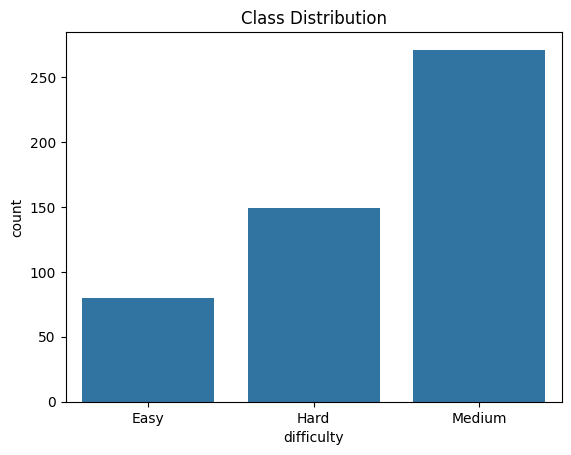

In [14]:
df.info()
df.describe()

sns.countplot(x="difficulty", data=df)
plt.title("Class Distribution")
plt.show()


In [15]:
X = df[["quiz_score", "time_spent", "attempts"]]
y = df["difficulty"]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (350, 3)
Validation: (75, 3)
Test: (75, 3)


In [17]:
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)

X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)


In [18]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [19]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # 3 difficulty classes
        )

    def forward(self, x):
        return self.model(x)

model = MLP().to(device)
print(model)


MLP(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [21]:
epochs = 50
best_val_acc = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            _, preds = torch.max(outputs, 1)
            total += yb.size(0)
            correct += (preds == yb).sum().item()

    val_acc = correct / total

    if val_acc > best_val_acc:
        best_val_acc = val_acc

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/50 | Train Loss: 11.7955 | Val Acc: 0.5467
Epoch 2/50 | Train Loss: 11.1923 | Val Acc: 0.5467
Epoch 3/50 | Train Loss: 10.7562 | Val Acc: 0.5467
Epoch 4/50 | Train Loss: 10.4860 | Val Acc: 0.5467
Epoch 5/50 | Train Loss: 10.0807 | Val Acc: 0.5467
Epoch 6/50 | Train Loss: 9.7874 | Val Acc: 0.5467
Epoch 7/50 | Train Loss: 9.2491 | Val Acc: 0.6267
Epoch 8/50 | Train Loss: 8.6988 | Val Acc: 0.6800
Epoch 9/50 | Train Loss: 7.9719 | Val Acc: 0.7467
Epoch 10/50 | Train Loss: 7.4565 | Val Acc: 0.7867
Epoch 11/50 | Train Loss: 6.6398 | Val Acc: 0.8133
Epoch 12/50 | Train Loss: 6.0836 | Val Acc: 0.8000
Epoch 13/50 | Train Loss: 5.6800 | Val Acc: 0.8133
Epoch 14/50 | Train Loss: 5.1472 | Val Acc: 0.8133
Epoch 15/50 | Train Loss: 4.7666 | Val Acc: 0.8533
Epoch 16/50 | Train Loss: 4.6111 | Val Acc: 0.8667
Epoch 17/50 | Train Loss: 4.1959 | Val Acc: 0.9067
Epoch 18/50 | Train Loss: 4.1472 | Val Acc: 0.9333
Epoch 19/50 | Train Loss: 3.8916 | Val Acc: 0.9333
Epoch 20/50 | Train Loss: 3.6397 | 

In [22]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_t)
    _, y_pred_nn = torch.max(outputs, 1)

nn_accuracy = (y_pred_nn == y_test_t).float().mean().item()
print("Neural Network Test Accuracy:", nn_accuracy)


Neural Network Test Accuracy: 0.9733333587646484


In [23]:
print(
    classification_report(
        y_test_t.cpu(),
        y_pred_nn.cpu(),
        target_names=label_encoder.classes_
    )
)


              precision    recall  f1-score   support

        Easy       0.92      0.92      0.92        12
        Hard       1.00      1.00      1.00        23
      Medium       0.97      0.97      0.97        40

    accuracy                           0.97        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.97      0.97      0.97        75



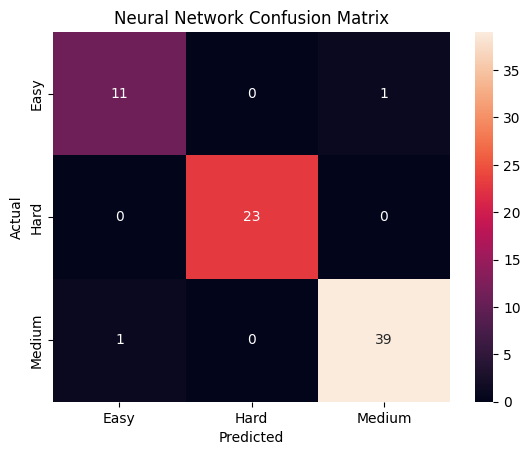

In [24]:
cm = confusion_matrix(y_test_t.cpu(), y_pred_nn.cpu())

sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Neural Network Confusion Matrix")
plt.show()


In [25]:
import os
os.makedirs("saved_models", exist_ok=True)

torch.save(model.state_dict(), "saved_models/mlp_model.pth")

import joblib
joblib.dump(scaler, "saved_models/scaler.pkl")
joblib.dump(label_encoder, "saved_models/label_encoder.pkl")

print("✅ Neural Network & preprocessors saved!")


✅ Neural Network & preprocessors saved!


In [26]:
loaded_model = MLP().to(device)
loaded_model.load_state_dict(torch.load("saved_models/mlp_model.pth"))
loaded_model.eval()

sample = np.array([[75, 30, 2]])
sample_scaled = scaler.transform(sample)
sample_t = torch.tensor(sample_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    pred = loaded_model(sample_t)
    _, pred_class = torch.max(pred, 1)

print("Predicted Difficulty:", label_encoder.inverse_transform(pred_class.cpu()))


Predicted Difficulty: ['Medium']


/home/vignesh/anaconda3/envs/custom/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
